**Note:** This project deadline was extended by one day in return for three late days among the contributors. 

## Problem statement 

We sought to analyze the equitability of access to programs in the My Chi. My Future. directory based on three different conditions: income levels and minority status, bilingualism/multilingualism, and crime rates.

We wanted to find out if Academic Support Programs were accessible to students attending schools with higher percentages of low income students as well as higher percentages of minority students. 

Considering that about 35% of the Chicago population speaks a language other than English at home, we sought to find the language distribution of the opportunities offered in Chicago. In specific we looked to analyze the equitability of the bilingual/multilingual opportunities listed in the directory based on quantity, geographic location and language distribution. 

Lastly, we wanted to analyze the relationship between the crime rate of an area and the number of programs available there. We wanted to see if program availability (and, more specifically, youth programs) has a role in reducing crime in historically high-crime areas, and what programs are most popular in low crime areas compared to high crime areas.


## Data sources

[My CHI. My Future. Programs](https://data.cityofchicago.org/Events/My-CHI-My-Future-Programs/w22p-bfyb/about_data)

This data set consists of many different youth programs Chicago between the years 2020 and 2024.

[Chicago Public Schools](https://data.cityofchicago.org/Education/Chicago-Public-Schools-School-Profile-Information-/83yd-jxxw/about_data)

This data set contains information on Chicago Public Schools for the 2020-21 school year. 

[Language Spoken at Home and Ability to Speak English](https://geodacenter.github.io/data-and-lab/Chi-CCA/)

Taken from the 2015-2019 American Community Survey, this table contains the population that speaks a certain language other than English and those that speaks only English at home per neighborhood in Chicago. 

[Crimes 2001-2022](https://data.cityofchicago.org/Public-Safety/Crimes-2022/9hwr-2zxp/about_data)

Records the crimes from 2001 to 2022 and contains the geographic location of where the crime occurred in Chicago. 

## Data quality check / cleaning / preparation 

In [81]:
#| echo: false

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import geopandas 
import folium
import geodatasets
import sklearn as sk
from sklearn.linear_model import LinearRegression
from scipy.stats import t


mychi = pd.read_csv('../stat 303-1/My_CHI._My_Future._Programs.csv')
mcmf = pd.read_csv('../stat 303-1/My_CHI._My_Future._Programs.csv')
programs_df = pd.read_csv('../stat 303-1/My_CHI._My_Future._Programs.csv')
cps_info = pd.read_csv('../stat 303-1/CPS_info.csv')
crime_df = pd.read_csv('../stat 303-1/crimes.csv')

### Distribution of Variables 

**My CHI. My Future. Data**

In [82]:
#| echo: false
mychi.describe()

,Program ID,Capacity,Min Age,Max Age,ZIP Code,Latitude,Longitude
count,227746.000000,2.207110e+05,227746.000000,227746.000000,220353.000000,219615.000000,219615.000000
mean,150406.844046,5.655422e+03,8.686647,44.162668,60629.190104,41.851651,-87.680025
std,36469.011260,7.016113e+05,6.518894,42.095325,27.371589,0.099947,0.118872
min,76358.000000,0.000000e+00,0.000000,0.000000,60018.000000,38.922466,-120.961998
25%,118969.250000,1.000000e+01,3.000000,12.000000,60617.000000,41.776459,-87.717003
50%,148861.500000,1.500000e+01,6.000000,18.000000,60628.000000,41.863098,-87.680382
75%,184012.750000,2.800000e+01,13.000000,99.000000,60641.000000,41.945400,-87.638603
max,211184.000000,9.910181e+07,65.000000,171.000000,66210.000000,42.147499,-87.530502


In [83]:
#| echo: false
# filtering categorical columns 
cat_columns = mychi.select_dtypes(include=['object', 'category'])

# showing the summary of categorical variables
summary = pd.DataFrame({
    'Missing Values': cat_columns.isnull().sum(),
    'Unique Values': cat_columns.nunique(),
    'Value Counts': [cat_columns[col].value_counts(dropna=False).to_dict() for col in cat_columns.columns]})

summary

,Missing Values,Unique Values,Value Counts
Program Name,0,30491,{'Ice Skating - Freestyle Ice (Studio Rink) at...
Description,0,42775,{'Designated practice time for figure skaters ...
Org Name,0,462,"{'Chicago Park District': 133258, 'Chicago Pub..."
Category Name,1,23,"{'Sports + Wellness.': 102187, 'Music & Art.':..."
Address,7316,1601,"{'3843 N. California Ave.': 11691, '810 E. 103..."
City,6196,27,"{'Chicago': 221475, nan: 6196, 'River Forest':..."
State,6196,3,"{'IL': 221368, nan: 6196, 'Illinois': 180, 'KS..."
Program Type,0,1,{'workshop': 227746}
Program URL,4358,110296,"{nan: 4358, 'https://youthreadychicago.cityspa..."
Online Address,218995,7030,"{nan: 218995, 'http://www.chicagoparkdistrict...."


**Chicago Public Schools Data**

In [84]:
#| echo: false
cps_info.describe()

,School_ID,Legacy_Unit_ID,Finance_ID,Zip,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,...,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available,Average_ACT_School,Mean_ACT,College_Enrollment_Rate_School,College_Enrollment_Rate_Mean,Graduation_Rate_School,Graduation_Rate_Mean,School_Latitude,School_Longitude
count,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,...,655.000000,655.000000,0.0,0.0,165.000000,165.0,141.000000,141.0,655.000000,655.000000
mean,569354.789313,5106.381679,36150.267176,60630.348092,503.621374,349.986260,74.438168,103.682443,181.512977,234.577099,...,0.735878,2.041221,NaN,NaN,57.155152,67.2,73.342553,78.9,41.841401,-87.677778
std,83074.064760,2534.237481,17548.073865,22.687433,402.438409,279.149048,55.878763,135.761314,198.149781,310.724929,...,2.407718,10.506870,NaN,NaN,25.298639,0.0,24.119199,0.0,0.089028,0.058023
min,400009.000000,1010.000000,0.000000,60602.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,NaN,NaN,0.000000,67.2,0.000000,78.9,41.653663,-87.841041
25%,609734.500000,2955.000000,23796.000000,60618.000000,267.000000,178.000000,38.000000,3.000000,26.500000,11.000000,...,0.000000,0.000000,NaN,NaN,39.700000,67.2,68.900000,78.9,41.771150,-87.716862
50%,609964.000000,4913.000000,26301.000000,60626.000000,408.000000,276.000000,62.000000,35.000000,137.000000,93.000000,...,0.000000,0.000000,NaN,NaN,63.200000,67.2,80.400000,78.9,41.845967,-87.678195
75%,610181.000000,7080.000000,47056.000000,60640.000000,625.500000,439.000000,91.500000,177.000000,274.500000,385.000000,...,1.000000,1.000000,NaN,NaN,77.500000,67.2,88.700000,78.9,41.910280,-87.639971
max,610597.000000,9935.000000,70241.000000,60827.000000,4382.000000,2669.000000,535.000000,747.000000,1961.000000,2573.000000,...,31.000000,203.000000,NaN,NaN,93.700000,67.2,99.100000,78.9,42.021091,-87.527985


In [85]:
#| echo: false
# filtering categorical columns 
cat_columns = cps_info.select_dtypes(include=['object', 'category'])

# showing the summary of categorical variables
summary = pd.DataFrame({
    'Missing Values': cat_columns.isnull().sum(),
    'Unique Values': cat_columns.nunique(),
    'Value Counts': [cat_columns[col].value_counts(dropna=False).to_dict() for col in cat_columns.columns]})

summary

,Missing Values,Unique Values,Value Counts
Short_Name,0,655,"{'PROVIDENCE ENGLEWOOD': 1, 'PATHWAYS - AVONDA..."
Long_Name,0,655,"{'Providence Englewood Charter School': 1, 'Pa..."
Primary_Category,0,3,"{'ES': 471, 'HS': 176, 'MS': 8}"
Summary,9,637,"{nan: 9, 'LEARN creates an intimate, resource-..."
Administrator_Title,0,2,"{'Principal': 536, 'Director': 119}"
...,...,...,...
Network,0,22,"{'Charter': 97, 'ISP': 82, 'Options': 36, 'Net..."
Is_GoCPS_Elementary,1,2,"{True: 427, False: 227, nan: 1}"
Open_For_Enrollment_Date,0,19,"{'09/01/2004': 516, '07/01/2012': 32, '07/01/2..."
Closed_For_Enrollment_Date,649,2,"{nan: 649, '06/30/2020': 4, '06/30/2021': 2}"


**Language Spoken at Home and Ability to Speak English**

In [86]:
#| echo: false
chicago = gpd.read_file("Chicago_2020.shp")
chicago_info = chicago.loc[:, ['community', 'geometry', 'TOT_POP', 'LING_ISO', 'ENGLISH', 'SPANISH', 'SLAVIC', 
                               'CHINESE', 'TAGALOG', 'ARABIC', 'KOREAN', 'OTHER_EURO']]
chicago_info.describe()

,TOT_POP,LING_ISO,ENGLISH,SPANISH,SLAVIC,CHINESE,TAGALOG,ARABIC,KOREAN,OTHER_EURO
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,35175.324675,4829.142857,21082.389610,7951.675325,962.207792,623.311688,268.051948,235.272727,105.493506,1045.662338
std,23094.415237,5640.808466,16785.046601,10730.523932,1615.527365,1640.672602,482.862024,500.654063,173.003774,1779.184294
min,2006.000000,45.000000,1884.000000,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18933.000000,337.000000,8809.000000,627.000000,37.000000,8.000000,0.000000,8.000000,0.000000,106.000000
50%,29936.000000,3214.000000,17769.000000,3385.000000,259.000000,71.000000,53.000000,52.000000,17.000000,309.000000
75%,45909.000000,8156.000000,26523.000000,12276.000000,1307.000000,422.000000,259.000000,226.000000,144.000000,1364.000000
max,101316.000000,26267.000000,80159.000000,54234.000000,9371.000000,10778.000000,2457.000000,3820.000000,687.000000,12650.000000


In [87]:
#| echo: false
chicago_cat = chicago_info.select_dtypes(include=['object'])
summary = pd.DataFrame({'Unique Values': chicago_cat.nunique(), 'Missing': chicago_cat.isnull().sum(), 'Value Counts': [chicago_cat[col].value_counts(dropna = False).to_dict() for col in chicago_cat.columns]})
summary

,Unique Values,Missing,Value Counts
community,77,0,"{'DOUGLAS': 1, 'SOUTH DEERING': 1, 'BRIGHTON P..."


**Chicago Crime Data**

In [88]:
#| echo: false
crime_df.describe()

,ID,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude
count,2.396200e+05,239620.000000,239620.000000,239610.000000,239620.000000,2.348850e+05,2.348850e+05,239620.0,234885.000000,234885.000000
mean,1.273171e+07,1154.060375,11.310892,23.384517,36.269427,1.165381e+06,1.887039e+06,2022.0,41.845613,-87.668600
std,7.082832e+05,707.912519,7.075574,14.210173,21.554607,1.679381e+04,3.229561e+04,0.0,0.088833,0.061010
min,2.654300e+04,111.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,2022.0,36.619446,-91.686566
25%,1.267804e+07,533.000000,5.000000,9.000000,22.000000,1.153949e+06,1.859284e+06,2022.0,41.769168,-87.710151
50%,1.276897e+07,1033.000000,10.000000,24.000000,32.000000,1.167255e+06,1.893383e+06,2022.0,41.863073,-87.661467
75%,1.285712e+07,1731.000000,17.000000,35.000000,53.000000,1.176856e+06,1.910066e+06,2022.0,41.909023,-87.626402
max,1.368384e+07,2535.000000,31.000000,50.000000,77.000000,1.205119e+06,1.951493e+06,2022.0,42.022548,-87.524532


In [89]:
#| echo: false
# filtering categorical columns 
cat_columns = crime_df.select_dtypes(include=['object', 'category'])

# showing the summary of categorical variables
summary = pd.DataFrame({
    'Missing Values': cat_columns.isnull().sum(),
    'Unique Values': cat_columns.nunique(),
    'Value Counts': [cat_columns[col].value_counts(dropna=False).to_dict() for col in cat_columns.columns]})

summary

,Missing Values,Unique Values,Value Counts
Case Number,0,239573,"{'JF198311': 3, 'JF445443': 3, 'JF356096': 3, ..."
Date,0,112310,"{'01/01/2022 12:00:00 AM': 150, '08/01/2022 12..."
Block,0,27970,"{'001XX N STATE ST': 604, '0000X W TERMINAL ST..."
IUCR,0,306,"{'0810': 20111, '0820': 18885, '0486': 18692, ..."
Primary Type,0,31,"{'THEFT': 54888, 'BATTERY': 40946, 'CRIMINAL D..."
Description,0,286,"{'SIMPLE': 27226, 'OVER $500': 20111, '$500 AN..."
Location Description,972,135,"{'STREET': 67643, 'APARTMENT': 45770, 'RESIDEN..."
FBI Code,0,26,"{'06': 54888, '08B': 33964, '14': 27247, '07':..."
Updated On,0,1566,"{'01/03/2023 03:40:27 PM': 227123, '11/15/2023..."
Location,4735,118346,"{nan: 4735, '(41.976290414, -87.905227221)': 3..."


Note that only some of the variables from the whole datasets are used for our individual analyses. Since the data is prepared differently for answering each question, see details about cleaning and preparation in the next section. 

## Exploratory Data Analysis

### Analysis 1: How does access to Academic Support Programs change when considering income levels and minority statuses?
*By Giovanni Cacciato*

To investigate accessibility to Academic Support Programs in the My Chi. My Future. directory based on income level and minority status, I used a Chicago Public Schools dataset from the 2020-21 school year. In cleaning this dataset, I dropped 2 virtual schools and 3 schools with student counts listed as zero. Additionally, I dropped two Academic Support Programs missing latitude-longitude pairs. In order to assess accessibility, I counted the number of in-person after school recurring Academic Support Programs offered for grade school-aged students (ages 5-21) within a mile radius of each school in the data (Near Programs), then analyzed this number for each school based on the percentages of low income and minority students. 

It is important to note that the correlation between the percentage of low income students and the percentage of minority students is very positively strong (r≈0.86) due to historical disadvantages and lack of social support overall (see figure below), so I expected similar results among the two factors when looking at the accessibility of Academic Support Programs. 

/var/folders/87/c47mf2zd1ts1w4gh05bwhwbc0000gn/T/ipykernel_11387/2294759022.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mychi['Start Time'] = pd.to_datetime(mychi['Start Time']).dt.hour


Text(0.5, 1.0, 'Percent Minority v. Percent Low Income in CPS')

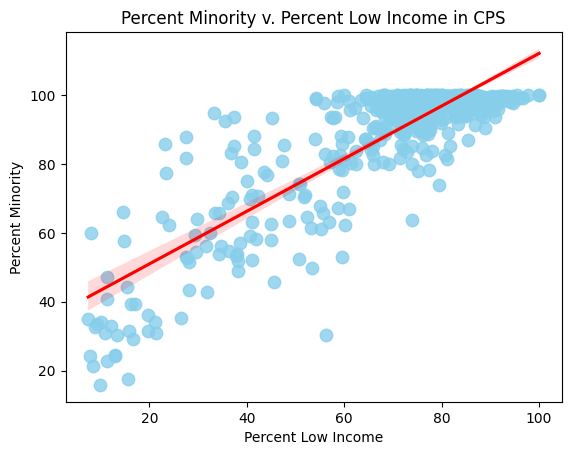

In [90]:
#| echo: false

######--------------for the mychi dataset--------------######

# retreiving the columns of the mychi dataset
mychi.columns.value_counts

# defining a list of columns to drop that are irrelevant to the information I seek (also will help with runtimes by getting rid of these)
mychi_columns_drop = ['Description', 'Org Name',
       'Capacity', 'Address', 'City',
       'State', 'ZIP Code', 'Program Type', 'Program URL', 'Online Address',
       'Registration URL', 'Registration Open', 'Registration Deadline',
       'End Time', 'Contact Name',
       'Contact Email', 'Contact Phone', 
       'Geographic Cluster Name', 'Scholarship Available', 'Participants Paid',
       'Transport Provided', 'Has Free Food', 'Image',
       'Hidden Programs', 'Featured', 'Custom Categories', 'Tag', 'Location']

# dropping irrelevant columns 
mychi.drop(columns=mychi_columns_drop, inplace=True)

# now we can isolate only the academic programs 
mychi = mychi[mychi['Category Name']=='Academic Support']

# now I need to examine if there are any missing values to be taken care of 
mychi['Program ID'].isnull().sum()
mychi['Category Name'].isnull().sum()
mychi['Min Age'].isnull().sum()
mychi['Max Age'].isnull().sum()
mychi['Meeting Type'].isnull().sum()
mychi['Latitude'].isnull().sum()
mychi['Longitude'].isnull().sum()
mychi['Start Time'].isnull().sum()
mychi['Start Date'].isnull().sum()
mychi['End Date'].isnull().sum()

# we are missing 3 values for latitude and longitude
# however, there is no way to impute these values given the dataset, and because they makeup roughly only 1% of the programs left, i will simply drop these programs 
mychi = mychi.dropna(axis=0)

# need to drop programs that occur virtually. doing this because determining the equitability of online programming is out of the scope of this project 
mychi = mychi[mychi['Meeting Type']!='online']

# in keeping with the fact that we are looking at programs for students, we need to drop programs whose min age is above 21
# also discard programs whose max age is less than 5 as those programs would not be meant for grade school students 
mychi = mychi[mychi['Min Age']<=21]
mychi = mychi[mychi['Max Age']>=5]

# max age also needs to be less than 21 as that is the oldest a someone is legally allowed to be considered a high school student 
mychi = mychi[mychi['Max Age']<=21]

# keeping only academic programs which begin after school ends (schools in chicago typically end around 3, so keep start times from 2pm and later)
mychi['Start Time'] = pd.to_datetime(mychi['Start Time']).dt.hour

# specifying 2pm as the earliest start time 
specified_time = pd.to_datetime('13:00:00').hour
# updating the dataset 
mychi = mychi[mychi['Start Time'] > specified_time]

# only keeping recurring programs 
mychi['Start Date'] = pd.to_datetime(mychi['Start Date'])
mychi['End Date'] = pd.to_datetime(mychi['End Date'])



######--------------for the cps dataset--------------######

# retreiving the columns of the cps dataset
cps_info.columns.value_counts

# defining a list of columns to drop that are irrelevant to the information I seek (also will help with runtimes by getting rid of these)
cps_columns_drop = ['School_ID', 'Legacy_Unit_ID', 'Finance_ID', 'Short_Name',
       'Is_Pre_School', 'Summary', 'Is_High_School', 'Is_Middle_School', 'Is_Elementary_School',
       'Administrator_Title', 'Administrator', 'Secondary_Contact_Title',
       'Secondary_Contact', 'Address', 'City', 'State', 'Zip', 'Phone', 'Fax',
       'CPS_School_Profile', 'Website', 'Facebook', 'Twitter', 'Youtube',
       'Pinterest', 'Attendance_Boundaries', 'Grades_Offered_All',
       'Grades_Offered','Student_Count_Special_Ed', 'Student_Count_English_Learners',
       'Student_Count_Other_Ethnicity', 'Student_Count_Asian_Pacific_Islander',
       'Student_Count_Multi', 'Student_Count_Hawaiian_Pacific_Islander',
       'Student_Count_Ethnicity_Not_Available', 'Statistics_Description',
       'Demographic_Description', 'Dress_Code', 'PreK_School_Day',
       'Kindergarten_School_Day', 'School_Hours', 'Freshman_Start_End_Time',
       'After_School_Hours', 'Earliest_Drop_Off_Time', 'Classroom_Languages',
       'Bilingual_Services', 'Refugee_Services', 'Title_1_Eligible',
       'PreSchool_Inclusive', 'Preschool_Instructional',
       'Significantly_Modified', 'Hard_Of_Hearing', 'Visual_Impairments',
       'Transportation_Bus', 'Transportation_El', 'Transportation_Metra',
       'Average_ACT_School', 'Mean_ACT', 'College_Enrollment_Rate_School',
       'College_Enrollment_Rate_Mean', 'Graduation_Rate_School',
       'Graduation_Rate_Mean', 'Overall_Rating', 'Rating_Status',
       'Rating_Statement', 'Classification_Description', 'School_Year',
       'Third_Contact_Title', 'Third_Contact_Name', 'Fourth_Contact_Title',
       'Fourth_Contact_Name', 'Fifth_Contact_Title', 'Fifth_Contact_Name',
       'Sixth_Contact_Title', 'Sixth_Contact_Name', 'Seventh_Contact_Title',
       'Seventh_Contact_Name', 'Network', 'Is_GoCPS_Participant',
       'Is_GoCPS_PreK', 'Is_GoCPS_Elementary', 'Is_GoCPS_High_School',
       'Open_For_Enrollment_Date', 'Closed_For_Enrollment_Date', 'Location']

# dropping the irrelevant columns 
cps_info.drop(columns=cps_columns_drop, inplace=True)

# checking to see if there are any null values to impute in the relevant columns 
cps_info['Long_Name'].isnull().sum()
cps_info['Student_Count_Low_Income'].isnull().sum()
cps_info['Student_Count_Total'].isnull().sum()
cps_info['School_Latitude'].isnull().sum()
cps_info['School_Longitude'].isnull().sum()
cps_info['Student_Count_Asian'].isnull().sum()
cps_info['Student_Count_Black'].isnull().sum()
cps_info['Student_Count_Hispanic'].isnull().sum()
cps_info['Student_Count_Native_American'].isnull().sum()
cps_info['Student_Count_White'].isnull().sum()
cps_info['Primary_Category'].isnull().sum()

# there are no missing values in the relevant columns of this dataset
# however, some schools have a total of 0 students-- I will drop these three schools

# this will show me the indices of the schools with no students 
cps_info[cps_info['Student_Count_Total']==0] 

# dropping schools with no students 
cps_info.drop([13, 318, 542], inplace=True)

# additionally, some schools are listed as virtual-- I will need to drop these as I am only exploring in-person opportunities across both datasets
# finding the indices of the virtual schools
cps_info[cps_info['Long_Name'].str.contains('Virtual')]

# dropping the virtual schools 
cps_info.drop([501, 618], inplace=True)

######--------------for the mychi dataset--------------######

# creating a new column with binned data
time_bins = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23, 24]
time_labels = ['00:00 - 1:00', '1:00-2:00', '2:00-3:00', '3:00-4:00', '4:00-5:00', '5:00-6:00', '6:00-7:00', '7:00-8:00', '8:00-9:00', '9:00-10:00', '10:00-11:00', '11:00-12:00', '13:00-14:00', '14:00-15:00', '15:00-16:00', '16:00-17:00', '17:00-18:00', '18:00-19:00', '19:00-20:00', '20:00-21:00', '21:00-22:00', '22:00-23:00', '23:00-24:00']
mychi['Binned Start Time'] = pd.cut(mychi['Start Time'], bins=time_bins, labels=time_labels, right=False)

# creating a column to indicate whether or not an opportunity is a program 
mychi['Is Program?'] = ((mychi['End Date'] - mychi['Start Date']).dt.days) > 5

# droppping the non-programs 
mychi = mychi[mychi['Is Program?']==True]



######--------------for the cps dataset--------------######

# defining a column which holds the percentage of students classified as low income 
cps_info['Percent Low Income'] = (cps_info['Student_Count_Low_Income']/cps_info['Student_Count_Total'])*100

# defining a column which determines whether or not a school is majority low-income (true=majority low income, false=minority low income)
cps_info['Majority Low Income'] = cps_info['Percent Low Income'] > 50

# defining a column that represents the percent minority population at each school 
cps_info['Percent Minority'] = 100*((cps_info['Student_Count_Black'] + cps_info['Student_Count_Asian'] + cps_info['Student_Count_Hispanic'] + cps_info['Student_Count_Native_American'])/cps_info['Student_Count_Total'])

# additionally adding columns to represent the percent of each race at each school
cps_info['Percent White'] = 100*(cps_info['Student_Count_White']/cps_info['Student_Count_Total'])
cps_info['Percent Black'] = 100*(cps_info['Student_Count_Black']/cps_info['Student_Count_Total'])
cps_info['Percent Asian'] = 100*(cps_info['Student_Count_Asian']/cps_info['Student_Count_Total'])
cps_info['Percent Hispanic'] = 100*(cps_info['Student_Count_Hispanic']/cps_info['Student_Count_Total'])
cps_info['Percent Native American'] = 100*(cps_info['Student_Count_Native_American']/cps_info['Student_Count_Total'])

# creating a column which holds the majority race at each school 
race_cols = ['Percent White', 'Percent Black', 'Percent Asian', 'Percent Hispanic', 'Percent Native American']
cps_info['Majority Race'] = cps_info[race_cols].idxmax(axis=1)

# creating a column to define the school type
# making a mask for the next step
charter_mask = cps_info['Long_Name'].str.contains('Charter')

# creating a new column where charter overrides any other category since charter schools have grade many grade levels that don't necessarily fit into the HS, MS, ES categories 
cps_info['School Type'] = cps_info.apply(lambda x: 'Charter' if charter_mask[x.name] else x['Primary_Category'], axis=1)

# isolating the latitude and longitude columns 
school_lat_long = cps_info.loc[:, ['School_Latitude', 'School_Longitude']]
program_lat_long = mychi.loc[:, ['Latitude', 'Longitude']]

# converting the latitude and longitude columns into numpy arrays for the following steps 
school_lat_long = np.array(school_lat_long)
program_lat_long = np.array(program_lat_long)

# reshaping such that I can work with these arrays together in the next step when computing distances 
school_lat = school_lat_long[:, 0].reshape(-1,1)
school_long = school_lat_long[:, 1].reshape(-1,1)
program_lat = program_lat_long[:,0]
program_long = program_lat_long[:,1]

# computing the distances between each school and academic support program
# this will return a 650x962 matrix with the distances 
distances = np.sqrt((school_lat-program_lat)**2 + (school_long-program_long)**2) 

# converting the names of programs and schools to lists so i can implement them in my distances dataframe 
program_list = mychi['Program Name'].to_list()
school_list = cps_info['Long_Name'].to_list()

# creating a dataframe which contains all the computed distances from schools to academic support programs 
distances_df = pd.DataFrame(distances)

# setting the index equal to the schools so that the dataframe is easier to read later 
distances_df = distances_df.set_index([school_list])

# in terms of euclidean distances, a distance of 0.015 equates to roughly a mile -- I will use this in the next steps to determine whether or not programs fall within the mile proximity of each school 
mile = 0.015 

# checking if each value is within one mile 
df_boolean = (distances_df <= mile)

# creating a new column to determine the number of near programs within 1 mile of each school 
df_boolean['Number of Near Programs'] = df_boolean.sum(axis=1)

# defining the number of near programs as a series so that I can merge with the cps_info dataframe 
num_near_programs = pd.Series(df_boolean['Number of Near Programs'])
cps_info.set_index('Long_Name', inplace=True)

# merging number of near programs column with the cps_info dataframe 
merged_df = cps_info.join(num_near_programs, how='inner')

# graphing percent minority students versus the percent low income students across chicago public schools  
sns.regplot(x='Percent Low Income', y='Percent Minority', data=merged_df, scatter_kws={'color': 'skyblue', 's': 80}, line_kws={"color": "red"})
plt.title('Percent Minority v. Percent Low Income in CPS')



Further, I hypothesized that there would be a negative trend in accessibility to Academic Support Programs for a rise in percentage of low income students, and a similar trend for a rise in percentage of minority students. So, I plotted the number of Near Programs against the Percent Low Income and Percent Minority in order to visualize my hypothesis. However, it was difficult to observe any trends that suggested this correlation on the surface level (see below figures). In fact, the plots show the opposite; a weak positive correlation suggesting that as schools have higher percentages of low income and minority students, there are more Near Programs. 

Text(0.5, 1.0, 'Percent Low Income v.\n Number of Near Programs')

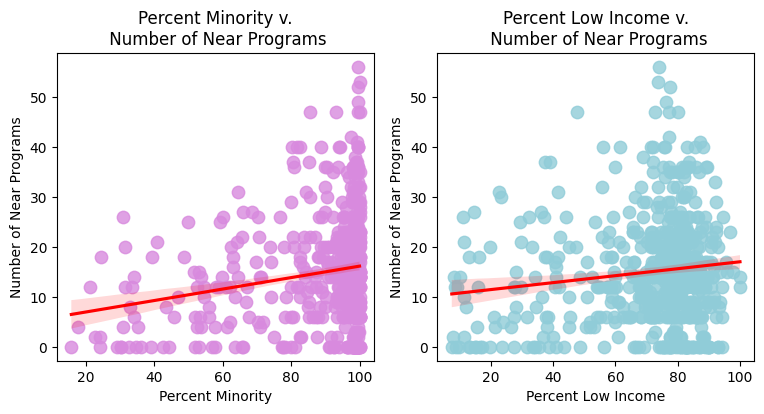

In [91]:
#| echo: false
# creating subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# plotting percent asian against number of near programs
sns.regplot(x='Percent Minority', y='Number of Near Programs', data=merged_df, scatter_kws={'color': '#D88ADE', 's': 80}, line_kws={"color": "red"}, ax=axes[0])
axes[0].set_title('Percent Minority v.\n Number of Near Programs')

# plotting percent native american against number of near programs
sns.regplot(x='Percent Low Income', y='Number of Near Programs', data=merged_df, scatter_kws={'color': '#90CCD8', 's': 80}, line_kws={"color": "red"}, ax=axes[1])
axes[1].set_title('Percent Low Income v.\n Number of Near Programs')

This was the opposite of what I expected, so I decided to dig a bit further and break the Percent Minority variable up by individual race. In doing so, I was able to see disparities in access to Academic Support Programs, specifically among schools with higher percentages of Hispanic students, and higher percentages of Native American students. Having weak negative correlation coefficients r≈-0.231 and r≈-0.046 respectively, a potential gap in accessibility to Academic Support Programs is suggested. 

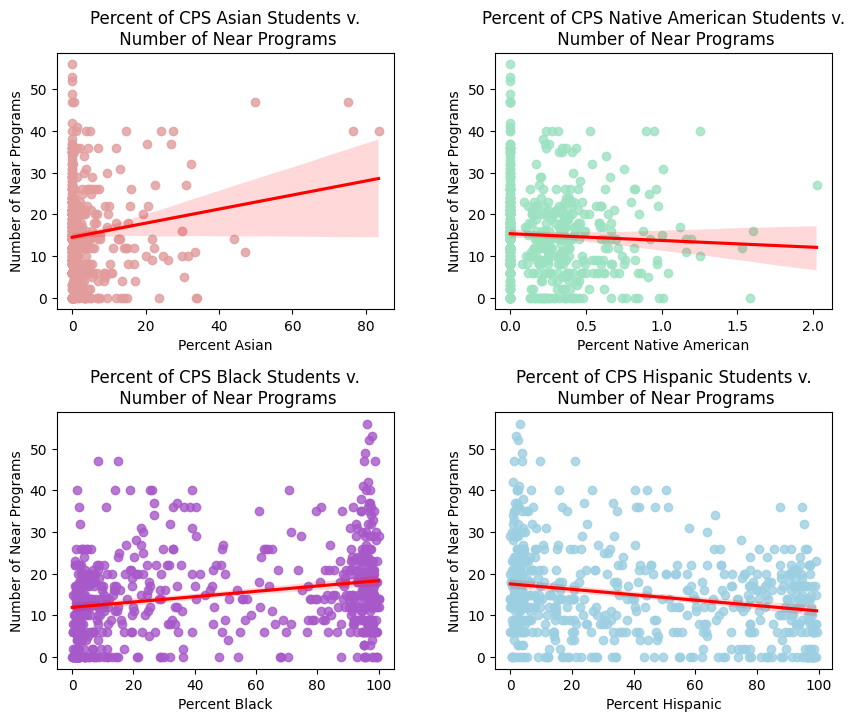

In [92]:
#| echo: false
# creating subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# plotting percent asian against number of near programs
sns.regplot(x='Percent Asian', y='Number of Near Programs', data=merged_df, scatter_kws={'color': '#E29C9C'}, line_kws={"color": "red"}, ax=axes[0, 0])
axes[0, 0].set_title('Percent of CPS Asian Students v.\n Number of Near Programs')

# plotting percent native american against number of near programs
sns.regplot(x='Percent Native American', y='Number of Near Programs', data=merged_df, scatter_kws={'color': '#9CE2C1'}, line_kws={"color": "red"}, ax=axes[0, 1])
axes[0, 1].set_title('Percent of CPS Native American Students v.\n Number of Near Programs')

# plotting percent black against number of near programs
sns.regplot(x='Percent Black', y='Number of Near Programs', data=merged_df, scatter_kws={'color': '#A758C9'}, line_kws={"color": "red"}, ax=axes[1, 0])
axes[1, 0].set_title('Percent of CPS Black Students v.\n Number of Near Programs')

# plotting percent hispanic against number of near programs
sns.regplot(x='Percent Hispanic', y='Number of Near Programs', data=merged_df, scatter_kws={'color': '#9CCFE2'}, line_kws={"color": "red"}, ax=axes[1, 1])
axes[1, 1].set_title('Percent of CPS Hispanic Students v.\n Number of Near Programs')

# adjusting to fix readability
plt.subplots_adjust(wspace=0.3, hspace=0.4)

Although the correlation coefficients are not strong enough to make a definitive claim about the association between the number of Near Programs and Percent Hispanic/Percent Native American students, they did prompt me to look deeper into the accessibility of these programs, this time based on Percent Low Income and 4 different school types: Elementary Schools (ES), Middle Schools (MS), High Schools (HS) and Charter Schools. I found that among High Schools with a majority hispanic student population, the number of Near Programs slightly decreases as Percent Low Income increases (r≈-0.166).


Text(0.5, 1.0, 'Percent Low Income v. Number of Near Programs Among High Schools with a Majority of Hispanic Students')

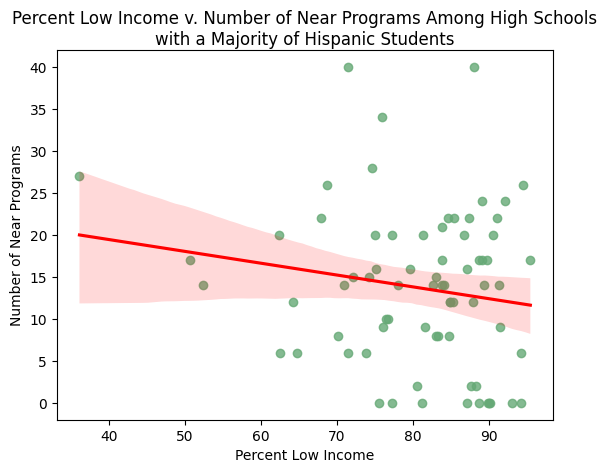

In [93]:
#| echo: false
# subsetting the data based on school type 
high_schools = merged_df[merged_df['School Type']=='HS']
middle_schools = merged_df[merged_df['School Type']=='MS']
elementary_schools = merged_df[merged_df['School Type']=='ES']
charter_schools = merged_df[merged_df['School Type']=='Charter']

# plotting percent low income versus number of near programs among majority hispanic high schools
hs_hispanic = high_schools[high_schools['Majority Race']=='Percent Hispanic']
sns.regplot(x='Percent Low Income', y='Number of Near Programs', data=hs_hispanic, scatter_kws={'color': '#66A976'}, line_kws={"color": "red"})
plt.title('Percent Low Income v. Number of Near Programs Among High Schools with a Majority of Hispanic Students', wrap=True)

Given the fact that among Chicago Public High Schools, roughly 45.1% have Hispanic students as their majority (see figure below), this is potentially a huge gap in Academic Support programming for this important student population. 

Text(0, 0.5, '')

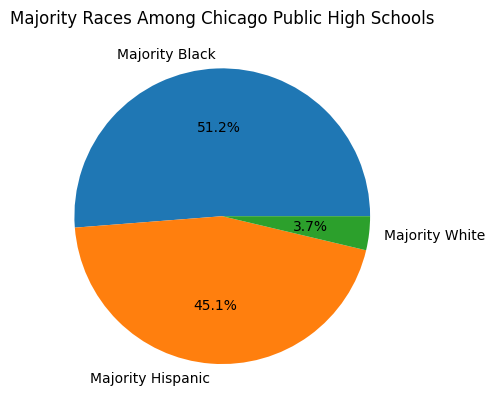

In [94]:
#| echo: false
# counting the number of majority race values in order to make a pie chart in the next step
count = high_schools['Majority Race'].value_counts()

# creating the pie chart
labels=['Majority Black', 'Majority Hispanic', 'Majority White']
count.plot(kind='pie', labels=labels, autopct='%1.1f%%')
plt.title('Majority Races Among Chicago Public High Schools')
plt.ylabel('')

Despite there being signs suggesting some possible gaps in Academic Support Programs specifically for Hispanic high school students in the Chicago area, the data also suggest that many schools with lower percentages of low income students (i.e., higher percentage of students who do not fall into the low income category) tend to have less access to Academic Support Programs. Additionally, schools with higher percentages of white students tend to have less access to Academic Support Programs, as well (see Appendix). Although these aren’t exactly issues that we are seeking to address for stakeholders in terms of equitability, it is interesting to see. 

### Analysis 2: How are bilingual/multilingual communities represented in the opportunities (events/resources/programs) taking place in Chicago?
*By Alexa Nuñez Magaña*

To examine if the distrubution of bilingual/multilingual opportunities was representative of the Chicago population, we first looked at the percetage and behavior of bilingual/multilingual opportunities compared to the English monolingual opportunities. In order to do this, the My Chi. My Future dataset was subsetted to only include bilingual/multilingual opportunities using text analysis with a list of keywords/keyphrases that would signal that a program is bilingual/multilingual and checking if the title and/or description of an opportunity contained one of said keywords/keyphrases. Additionally, duplicate opportunities were droped as the programs’ categories were not relevant to this analysis.

We looked at the percentage of bilingual/multilingual vs monolingual opportunities in the dataset and compared it to the percentage of the Chicago population that speaks a language other than English at home given by the 2023 US census data.

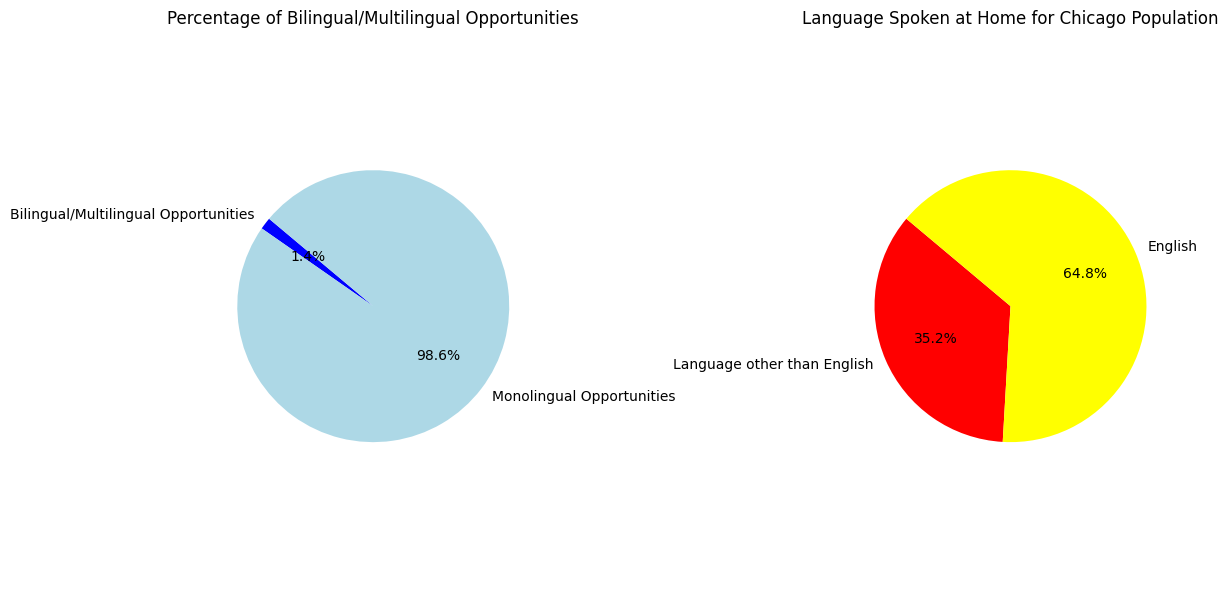

In [95]:
#| echo: false

mcmf = pd.read_csv('My_CHI._My_Future._Programs.csv')

# List of keywords/keyfrases that would signal that one of the opportunities in the dataset is bilingual/multilingual
keywords = ['bilingual', 'multilingual', 'english and', 'polish', 'language learning', 'language skills', 'french conversation', 'spanish conversation',
            'spanish language', 'french language', 'korean-speaking']

# Subset of data that indicates bilngual/multilingual opportunities based on their title. 
bilingual_title = mcmf[mcmf['Program Name'].apply(lambda x: any(word in x.lower() for word in keywords))]

# Subset of data that indicates bilingual/multilingual opportunities based on their description.
bilingual_description = mcmf[mcmf['Description'].apply(lambda x: any(word in x.lower() for word in keywords))]

# Joining the two subsets and dropping duplicate events.
bilingual_opportunities = pd.concat([bilingual_title, bilingual_description]).drop_duplicates(subset= 'Program ID').reset_index(drop=True)

# Droping columns that are irrelevant to my analysis.
bilingual_opportunities = bilingual_opportunities.drop(columns= ['Org Name','Capacity', 'Program Type', 'Program URL', 'Online Address',
                                                               'Registration URL', 'Registration Open', 'Registration Deadline','Start Time',
                                                               'End Time', 'Contact Name', 'Contact Email', 'Contact Phone', 'Scholarship Available',
                                                               'Participants Paid', 'Transport Provided', 'Has Free Food', 'Image', 'Hidden Programs',
                                                               'Featured', 'Custom Categories', 'Tag'])

# Droping the following opportunities as they have language skill in their description yet do not serve the bilingual/multilingual community.
bilingual_opportunities = bilingual_opportunities[(bilingual_opportunities['Program Name'] != 'Baby Time') & ('Adult Book Club' not in bilingual_opportunities['Program Name'])]

mcmf_no_duplicates = mcmf.drop_duplicates(subset= 'Program ID').reset_index(drop = True)
monolingual_op = mcmf_no_duplicates.shape[0] - bilingual_opportunities.shape[0]

# Creating a figure with two pie charts

labels_op = ['Bilingual/Multilingual Opportunities', 'Monolingual Opportunities']
labels_census = ['Language other than English', 'English']

sizes_op = [bilingual_opportunities.shape[0], monolingual_op]
sizes_census = [35.2, 64.8] # Proportion gotten from the US Census not a dataset

colors_op = ['blue', 'lightblue']
colors_census = ['red', 'yellow']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# Plot the first pie chart
axes[0].pie(sizes_op, labels = labels_op, colors= colors_op, autopct='%1.1f%%', startangle=140)
axes[0].axis('equal')  
axes[0].set_title('Percentage of Bilingual/Multilingual Opportunities')

# Plot the second pie chart
axes[1].pie(sizes_census, labels = labels_census, colors = colors_census, autopct='%1.1f%%', startangle=140)
axes[1].axis('equal') 
axes[1].set_title('Language Spoken at Home for Chicago Population')
plt.tight_layout()  
plt.show()

This visualization allows us to see the striking difference between the percentage of bilingual/multilingual opportunities and the actual bilingual/multilingual population in Chicago. To look further into this gap we wanted to look at the amount of new bilingual/multilingual opportunities per year.

([<matplotlib.axis.XTick at 0x2c57f01a0>,
 [Text(2021, 0, '2021'),
  Text(2022, 0, '2022'),
  Text(2023, 0, '2023'),
  Text(2024, 0, '2024')])

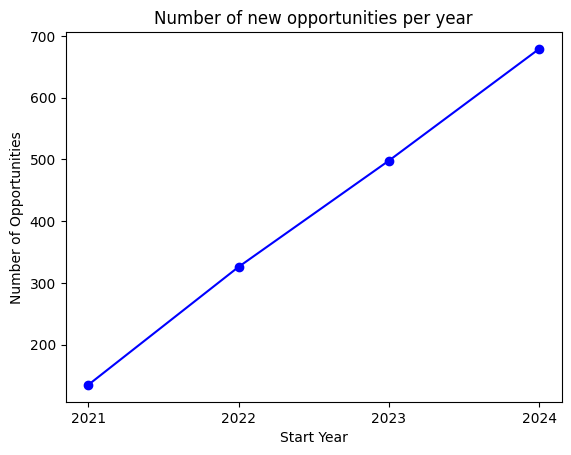

In [96]:
#| echo: false
bilingual_opportunities['Start Date'] = pd.to_datetime(bilingual_opportunities['Start Date'])
bilingual_opportunities['Start Year'] = bilingual_opportunities['Start Date'].dt.year

bilingual_opportunities['End Date'] = pd.to_datetime(bilingual_opportunities['End Date'])
bilingual_opportunities['End Year'] = bilingual_opportunities['End Date'].dt.year


# Creating a line plot with the number of bilingual opportunities starting every year.
event_per_year = bilingual_opportunities['Start Year'].value_counts().sort_index()
event_per_year.plot(kind='line', marker='o', color='b')
years = event_per_year.index
plt.ylabel('Number of Opportunities')
plt.title('Number of new opportunities per year')
plt.xticks(years)

As we can see, the amount of bilingual/multilingual opportunities has steadily increased over the years. Although this is a promising trend to create a more representative number of opportunities for the Chicago population, we wanted to take a closer look at 2024, the year with the most number of new bilingual/multilingual opportunities, and analyze whether or not there were any changes gap found above.

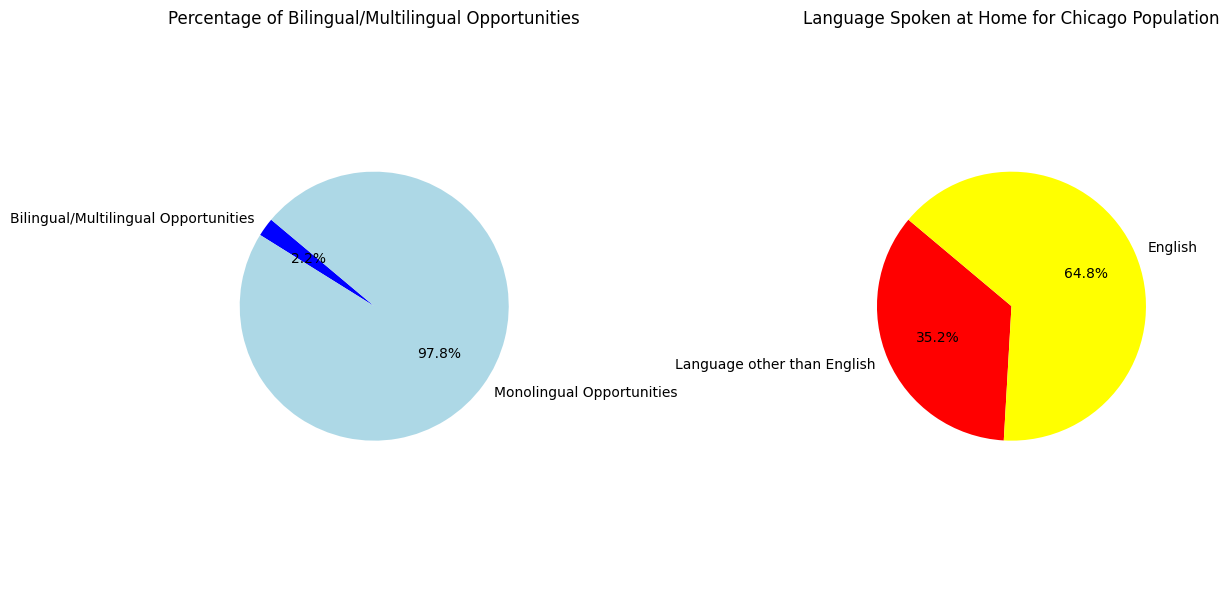

In [97]:
#| echo: false
# Getting Start date in datetime format
mcmf_no_duplicates['Start Date'] = pd.to_datetime(mcmf_no_duplicates['Start Date'])
mcmf_no_duplicates['Start Year'] = mcmf_no_duplicates['Start Date'].dt.year

monolingual_op = mcmf_no_duplicates[mcmf_no_duplicates['Start Year'] == 2024].shape[0] - bilingual_opportunities[bilingual_opportunities['Start Year'] == 2024].shape[0]

# Creating a figure with two pie charts. 

labels_op = ['Bilingual/Multilingual Opportunities', 'Monolingual Opportunities']
labels_census = ['Language other than English', 'English']

sizes_op = [bilingual_opportunities[bilingual_opportunities['Start Year'] == 2024].shape[0], monolingual_op]
sizes_census = [35.2, 64.8]

colors_op = ['blue', 'lightblue']
colors_census = ['red', 'yellow']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# Plot the first pie chart
axes[0].pie(sizes_op, labels = labels_op, colors= colors_op, autopct='%1.1f%%', startangle=140)
axes[0].axis('equal')  
axes[0].set_title('Percentage of Bilingual/Multilingual Opportunities')

# Plot the second pie chart
axes[1].pie(sizes_census, labels = labels_census, colors = colors_census, autopct='%1.1f%%', startangle=140)
axes[1].axis('equal') 
axes[1].set_title('Language Spoken at Home for Chicago Population')

plt.tight_layout()  
plt.show()

Although the gap between bilingual/multilingual opportunities and the bilingual/multilingual population of Chicago is smaller when only looking at 2024, said gap is still substantially large. This starting analysis suggests that there already is a lack of equitability in opportunities for the bilingual/multilingual population based on quantity alone. Yet, We wanted to further explore the distribution and equitability of the existing bilingual/multilingual opportunities.

In order to achieve this analysis, we looked into the language demographics of each Chicago neighborhood using an interactive map with the help of the “Language Spoken at Home and Ability to Speak English” table from the 2015-2019 American Community Survey. To get a better analysis of the data an ‘other/unspecified’ column was added that included the difference between the sum of all the columns of languages spoken at home and the total population of the neighborhood. Additionally, a column including the amount of the population that did not speak only English at home was added to the dataset which was then used to compute the poportion of the non-English-only population per neighborhood. Lastly, a column including the most spoken language other than English was added for each neighborhood.

As for the My Chi. My Future dataset, since this analysis was dependent on the geographical distribution of the opportunities, online opportunities were omitted from this part of the analysis. Because the data was not categorized into compatible neighborhood labels as the “Language Spoken at Home” dataset, we used the latitude and longitude columns to find the location of each opportunity based on the coordinate reference system of the “Language Spoken at Home” dataset, since there were no missing values for either the latitude or longitude for any of the observations no further problems were encountered. Additionally, we wanted to look at the most offered language for the bilingual/multilingual opportunities of each neighborhood for which we created a “language” column that stored the languages other than English mentioned in the title or description of each opportunity. We then grouped by the neighborhood and opportunity languages to get the language with the maximum amount of counts. Lastly by grouping by “geographic cluster” (neighborhood) and “start year” we got the average amount of opportunities per year on each neighborhood.

In [98]:
#| echo: false
# A list of language according to the most spoken languages in Chicago.
languages = ['Spanish', 'French', 'Chinese', 'Arabic', 'Polish', 'Persian', 'ASL', 'Korean', 'Tagalog', 'Slavic', 'Russian', 'Urdu', 'Hindi', 'Czech', 'Ukranian', 'Slovak']

# Defining a function that finds and returns the languages of and event. If no languages are found then 'Unspecified' is returned.
def op_languages(description):
    found = [lang for lang in languages if lang.lower() in description.lower()]
    return ', '.join(found) if found else 'Unspecified'

# Applying the function to the 'description' column to create an 'opportunity language' column
bilingual_opportunities['opportunity language'] = bilingual_opportunities['Description'].apply(op_languages)

# Reading the Chicago language dataset and only including the columns relevant to my analysis.
chicago = gpd.read_file("Chicago_2020.shp")
chicago_info = chicago.loc[:, ['community', 'geometry', 'TOT_POP', 'LING_ISO', 'ENGLISH', 'SPANISH', 'SLAVIC', 
                               'CHINESE', 'TAGALOG', 'ARABIC', 'KOREAN', 'OTHER_EURO']]

# Creating a column that includes the number of non-English speakers whose language is not specified. 
chicago_info['OTHER_UNSPEC'] = chicago_info['TOT_POP'] - chicago_info.iloc[:, 4:].sum(axis = 1)

# Creating a column that includes the number of non-English speakers per neighborhood.
chicago_info['NOT_ENGLISH'] = chicago_info['TOT_POP'] - chicago_info['ENGLISH']

# Creating a column that includes the proportion of non-English speaker per neighborhood.
chicago_info['NOT_ENGLISH_PROP'] = ((chicago_info['NOT_ENGLISH'])/chicago_info['TOT_POP'])*100

# Excluding online events since they are irrelevant for this part of the analysis.
bilingual_person_ops = bilingual_opportunities[bilingual_opportunities['Meeting Type'] != 'online']

# Getting the longitude and latitude in Point format.
geometry = gpd.points_from_xy(bilingual_person_ops['Longitude'], bilingual_person_ops['Latitude'])

# Creating a GeoDataFrame containing the information of the in person bilingual programs.
geo_bilingual = gpd.GeoDataFrame(bilingual_person_ops, geometry= geometry)

# Setting the Coordinate Reference System to the Coordinate Reference System of the chicago dataset
geo_bilingual = geo_bilingual.set_crs(chicago_info.crs, allow_override=True)

# Joining the two datasets.
gdf = gpd.sjoin(geo_bilingual, chicago_info, how="left", predicate="within")

# Overriding the data in the Geographic Cluster Name column with that of the 'community' column so that the neighborhood's names are the same.
bilingual_person_ops['Geographic Cluster Name'] = gdf['community']
geo_bilingual = gpd.GeoDataFrame(bilingual_person_ops, geometry= geometry)

# Grouping the event based on their start year.
yearly_counts = bilingual_person_ops.groupby(['Geographic Cluster Name', 'Start Year']).size().reset_index(name = 'opportunities')

# Getting the average number of opportunitites that start every year per neighborhood.
ops_per_area = yearly_counts.groupby('Geographic Cluster Name')['opportunities'].mean().reset_index()

# Merging the chicago dataset with the mean opportunities per neighborhoods each year. 
ops_per_area.rename(columns={'Geographic Cluster Name': 'community'}, inplace=True)
chicago_info = pd.merge(chicago_info, ops_per_area, on='community', how='left')
chicago_info['opportunities'].fillna(0, inplace=True)

# Finding the most offered language other than English of opportunities in each neighborhood.

language_counts = bilingual_person_ops.groupby(['Geographic Cluster Name', 'opportunity language']).size()
most_frequent_language_idx = language_counts.groupby('Geographic Cluster Name').idxmax()
most_frequent_language = language_counts.loc[most_frequent_language_idx].reset_index()[['Geographic Cluster Name', 'opportunity language']]

# Merging the chicago dataset with the most offered event language other than English.

most_frequent_language.rename(columns = {'Geographic Cluster Name': 'community'}, inplace=True)
chicago_info = pd.merge(chicago_info, most_frequent_language, on='community', how='left')
chicago_info['opportunity language'].fillna('No opportunities', inplace=True)

# Language columns of the Chicago language dataset.
language_columns = ['SPANISH', 'SLAVIC', 'CHINESE', 'TAGALOG', 'ARABIC', 'KOREAN', 'OTHER_EURO']

# Defining a function that finds the most spoken non-English language and the proportion of speakers in each neighborhood.
def most_spoken_language(area):
    # Filters out rows where all language values are zero
    language_speakers = area[language_columns]
    
    most_spoken_language = language_speakers.idxmax()  
    max_value = language_speakers.max()  
    
    # Calculating the percentage of the most spoken language.
    percentage = (max_value / area['TOT_POP']) * 100
    
    return f"{most_spoken_language}: {int(percentage)}%"

# Applies the function to each row in the dataframe.
chicago_info['most spoken language other than English'] = chicago_info.apply(most_spoken_language, axis=1)

# Creating an interactive map with the information found above

m = chicago_info.explore(
    column="NOT_ENGLISH_PROP", 
    scheme="naturalbreaks",  
    legend=True,  
    k=10,  
    tooltip= ['community','most spoken language other than English', 'opportunities', 'opportunity language'],  # hide tooltip
    legend_kwds=dict(colorbar=False),  
    name="chicago",  
)
m

/var/folders/87/c47mf2zd1ts1w4gh05bwhwbc0000gn/T/ipykernel_11387/3565055223.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bilingual_person_ops['Geographic Cluster Name'] = gdf['community']
/var/folders/87/c47mf2zd1ts1w4gh05bwhwbc0000gn/T/ipykernel_11387/3565055223.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation

This map can help us uncover two problems with the equitability of bilingual/multilingual opportunities for the Chicago population. The first problem is that there are neighborhoods (such as East Side, West Elsdon, Hegewisch, etc.) with a very high percentage of bilingual population yet no offered bilingual/multilingual programs. The second problem can be found in neighborhoods such as Norwood Park and Firest Glen where the most language spoken other than English doesn’t match the most offered language for the opportunities. Thus, aside from the lack of bilingual/multilingual opportunities, there is also a misditribution of the existing programs which fail to both reach the neighborhoods with higher bilingual/multilingual populations while also failing to accurately represent the bilingual/multilingual linguistic need of some neighborhoods.

This last problem was of special interest to us as it raised the question of whether or not the linguistic distribution of the bilingual/multilingual opportunities matched the linguistic distribution of the bilingual/multilingual Chicago population. No additional columns were created to complete this analysis.

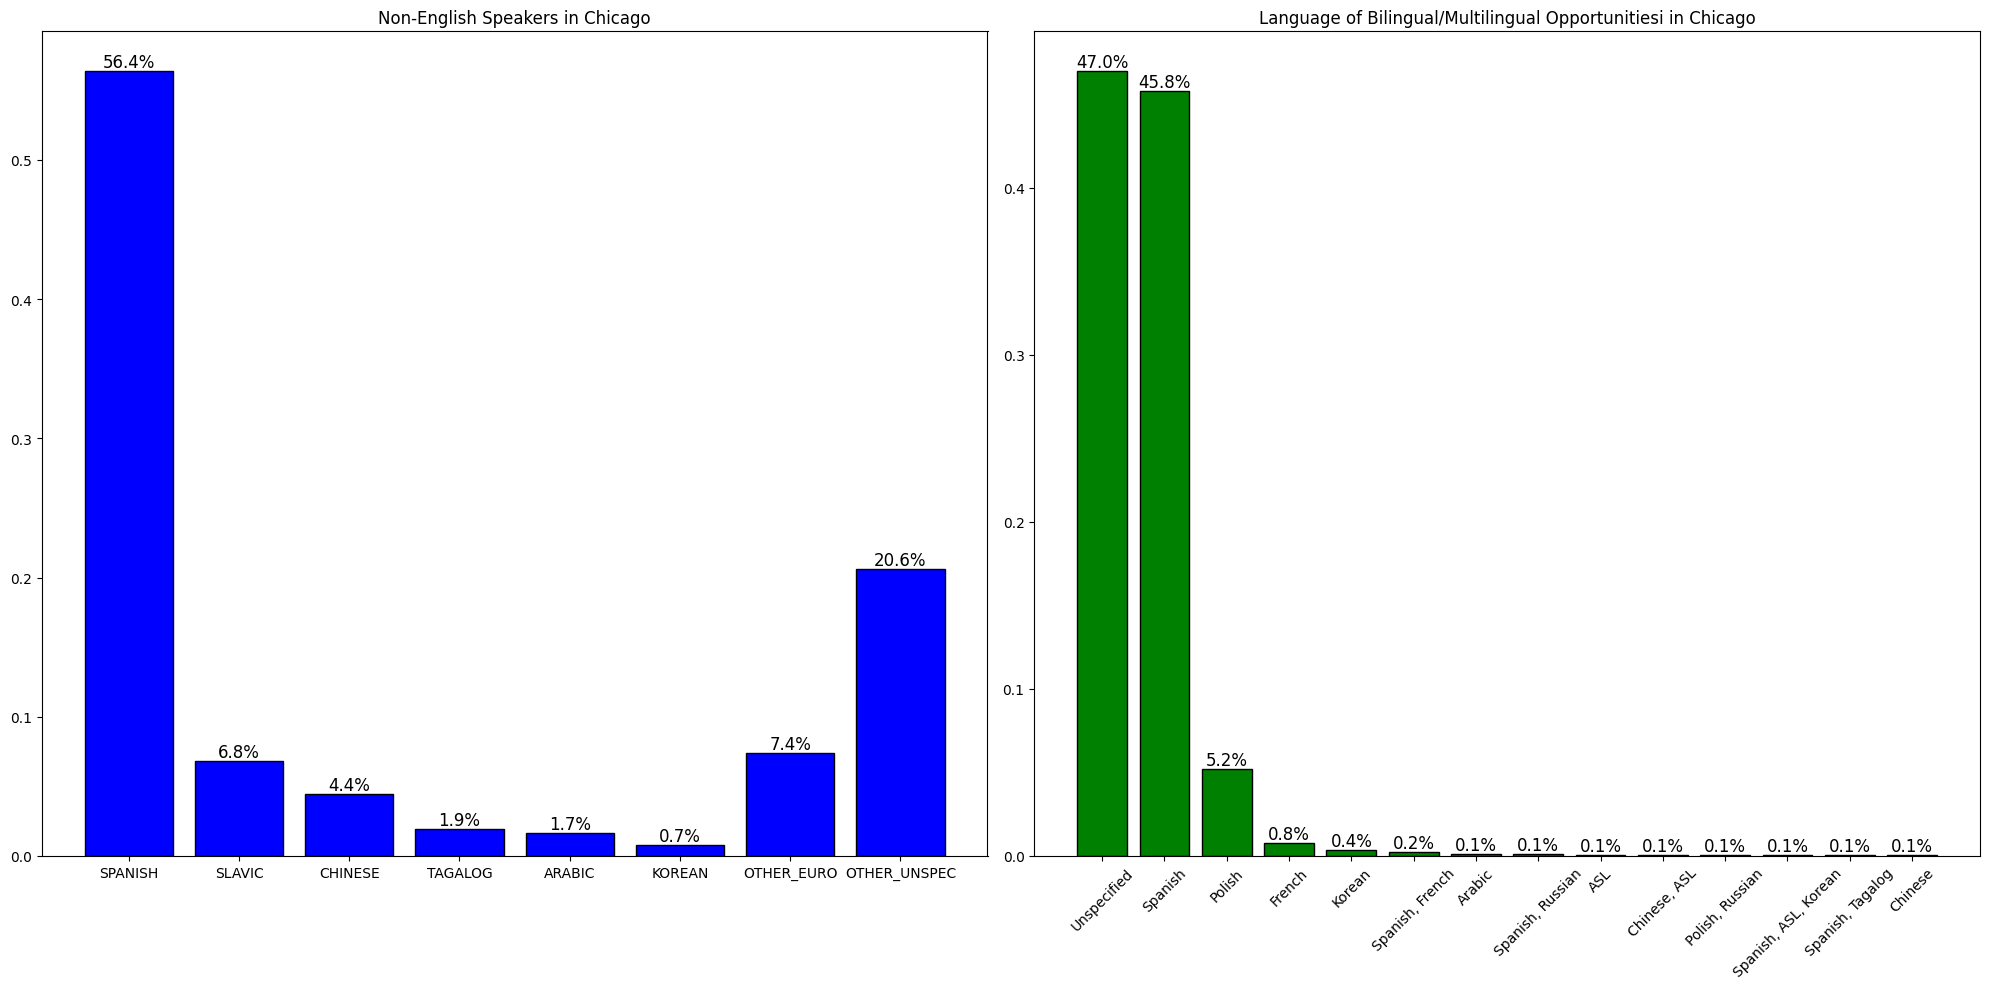

In [99]:
#| echo: false
# Finding the proportion of the offered languages in bilingual opportunities.
language_counts = bilingual_opportunities['opportunity language'].value_counts()
language_proportions = language_counts / bilingual_opportunities.shape[0]


# Finding the proportion of speakers of each language in Chicago. 
non_english_proportions = chicago_info.loc[:, ['NOT_ENGLISH','SPANISH', 'SLAVIC', 'CHINESE', 'TAGALOG', 'ARABIC', 'KOREAN', 'OTHER_EURO',
                                               'OTHER_UNSPEC']]

non_english_proportions = non_english_proportions.sum(axis = 0)
proportions = non_english_proportions.drop('NOT_ENGLISH') / non_english_proportions['NOT_ENGLISH']

# Creating two barplots that show the distributions of spoken non-English languages in Chicago and the distribution of the languages offered in bilingual opportunities in Chicago.

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

bars = axes[0].bar(proportions.index, proportions, color='blue', edgecolor = 'black')
axes[0].set_title('Non-English Speakers in Chicago')
axes[0].bar_label(bars, labels=[f'{value:.1%}' for value in proportions], fontsize=12)

bars1 = axes[1].bar(language_proportions.index, language_proportions, color='green', edgecolor='black')
axes[1].bar_label(bars1, labels=[f'{value:.1%}' for value in language_proportions], fontsize=12)
axes[1].set_title('Language of Bilingual/Multilingual Opportunitiesi in Chicago')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

Comparing the two linguistic distributions we can confirm our previous suspicion that there was a lack of representation between the languages offered in bilingual/multilingual opportunities and the languages spoken in the Chicago population. To be more specific it seems that there is a lack of representation of the non-Spanish bilingual/multilingual population based on the gap between the percentage of non-Spanish speakers and the percentage of bilingual/multilingual opportunities in said language. Furthermore, a second problem is found, one that could cause a lack of accuracy in the previous analysis of the language distribution: 47.3% of the bilingual/multilingual opportunities failed to specify which languages were offered/used/invited. Appart from hindering the accuracy in the analysis of the language distribution of opportunities, this lack of specificity could cause hesitation towards the bilingual/multilingual population as they wonder if their language-pair will be represented in a space were there seems to be an overgeneralization of “bilingual/multilingual” as refering to “Spanish-English speaker”.

### Analysis 3: Are areas with higher crime rates associated with fewer programs or programs of specific categories? What about youth-related programs?
*By Danny Ramirez*



First, we want to look at the relationship between program count and crime count within the grid cells. Next, we’ll look at the statistical significance of our regression coefficient.

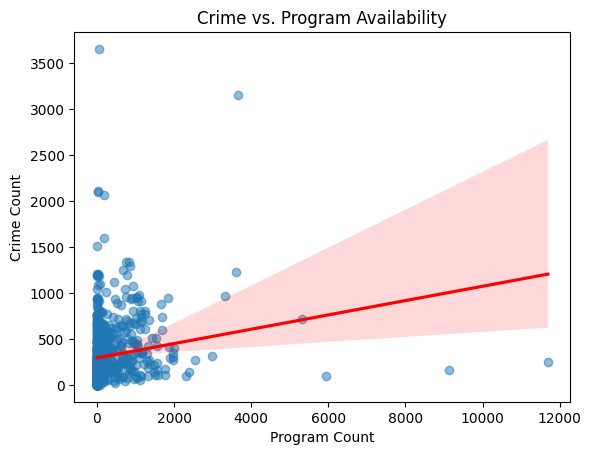

Correlation: 0.17139145663437833
Coefficient: 0.07790756999264808
Standard Error: 0.016484965299981814
T-statistic: 4.725977190424175
P-value: 2.7426170534639027e-06


In [100]:
#| echo: false
#Keeping the columns needed
crime_df = crime_df[['Latitude', 'Longitude']]
programs_df = programs_df[['Latitude', 'Longitude', 'Category Name', 'Max Age', 'Program Type']]

#Determining the max amount of data that was missing to see if I should impute data or filter it out
crime_df.isnull().sum().max()/crime_df.shape[0] # = 0.0197 meaning that less than 2% of the data is missing a value in Latitude/Longitude, so I will filter them out
programs_df.isnull().sum().max()/programs_df.shape[0] # =0.0357 meaning that 3.6% of the data is missing a value in Latitude/Longitude, so I will filter them out

#Filtering out the data that is missing a Latitude/Longitude value
crime_df = crime_df.dropna(subset=['Latitude', 'Longitude'])
programs_df = programs_df.dropna(subset=['Latitude', 'Longitude'])

#Creating a Grid column for both datasets that consists of the Latitude and Longitude values rounded to 2 significant digits
crime_df['Grid'] = crime_df['Latitude'].round(2).astype(str) + '_' + crime_df['Longitude'].round(2).astype(str)
programs_df['Grid'] = programs_df['Latitude'].round(2).astype(str) + '_' + programs_df['Longitude'].round(2).astype(str)

#Grouping both datasets by Grid and determining how many Crimes/Programs are in the Grid cell
crime_grid_counts = crime_df.groupby('Grid').size().reset_index(name='Crime Count')
program_grid_counts = programs_df.groupby('Grid').size().reset_index(name='Program Count')

#Merging the two datasets so that each Grid cell has a value for both Crime Count and Program Count
combined_data = pd.merge(crime_grid_counts, program_grid_counts, on='Grid', how='outer').fillna(0)

#Generate scatterplot
sns.regplot(
    x='Program Count',
    y='Crime Count',
    data=combined_data,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
    ci=95
)
plt.xlabel('Program Count')
plt.ylabel('Crime Count')
plt.title('Crime vs. Program Availability')
plt.show()

#Prepare data
X = combined_data['Program Count'].values.reshape(-1, 1)
y = combined_data['Crime Count'].values
model = LinearRegression()
model.fit(X, y)

#Get predictions and residuals
y_prediction = model.predict(X)
residuals = y - y_prediction

#Calculate standard error of beta 1 hat
n = len(y)  #Number of observations
k = 1  #Number of predictors (linear regression so =1)
ssr = np.sum(residuals**2)  #Sum of squares regression
se = np.sqrt(ssr / (n - k - 1)) / np.sqrt(np.sum((X - np.mean(X))**2))  #Standard error of beta 1 hat

#Calculate t-statistic
beta_one_hat = model.coef_[0]
t_stat = beta_one_hat / se

#Calculate p-value (two-tailed) and correlation
p_value = 2 * (1 - t.cdf(abs(t_stat), df=n - k - 1))
corr = combined_data['Crime Count'].corr(combined_data['Program Count'])

print(f"Correlation: {corr}")
print(f"Coefficient: {beta_one_hat}")
print(f"Standard Error: {se}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

We observe that there is a weak but positive correlation between the two. Our coefficient of **0.0779** means that *for each additional program in a grid cell, the crime counts increase by approximately 0.0779 crimes on average*. This positive relationship means that areas with more programs tend to have slightly higher crime rates. We then tested the coefficient with a t-test. The code accounts for the degrees of freedom, so although heteroscedasticity is assumed, the code accounts for if it is not. We calculated a t-statistic of **4.73**, which led to a p-value of **< 0.0001**. We reject the null at the 5% level, meaning that the coefficient is statistically significant. To explain this relationship, high-crime areas might attract more programs (such as intervention programs, community-oriented programs, etc.). It’s also possible that factors such as population density, socioeconomic status, or pre-existing infrastructure of the grid cell might influence both crime rates and program availability.

Here, we just wanted to get a closer look at the scatterplot. To do this, we regenerate the scatterplot filtering out grid cells where the number of crimes exceeds 3000 and the number of programs exceeds 1500.

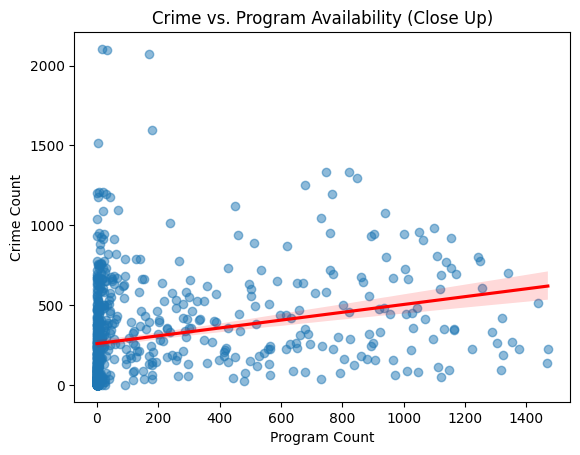

In [101]:
#| echo: false
#Capping crime and programs to get a closeup on the graph
crime_threshold = 3000  #Keep only cells with <= 3000 crimes
program_threshold = 1500  #Keep only cells with <= 1500 programs

# Filter data
filtered_data = combined_data[
    (combined_data['Crime Count'] <= crime_threshold) &
    (combined_data['Program Count'] <= program_threshold)
]

#Generate scatterplot
sns.regplot(
    x='Program Count',
    y='Crime Count',
    data=filtered_data,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
    ci=95
)
plt.xlabel('Program Count')
plt.ylabel('Crime Count')
plt.title('Crime vs. Program Availability (Close Up)')
plt.show()

Next, we wanted to look at the relationship between the youth program count and crime count within the grid cells. Again, we’ll look at the statistical significance of our regression coefficient.

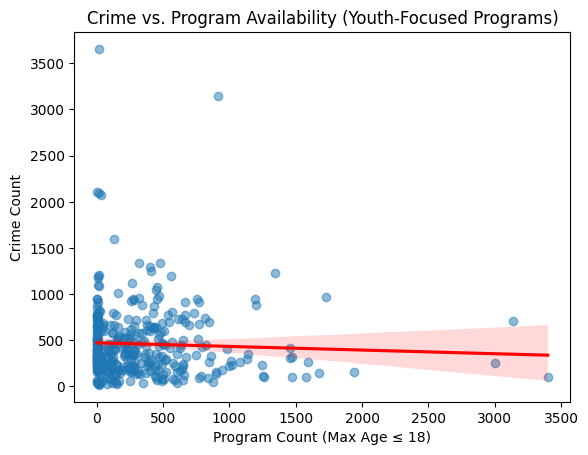

Correlation: -0.044430847998046225
Coefficient: -0.039523322116876
Standard Error: 0.04638811375581901
T-statistic: -0.852013994897952
P-value: 0.3947619573520682


In [102]:
#| echo: false
#Keeping only program counts that are less than 18
youth_programs = programs_df[programs_df['Max Age'] <= 18]

#Recalculating program counts by location and then merging with crime data
youth_program_counts = youth_programs.groupby('Grid').size().reset_index(name='Program Count')
filtered_youth_data = pd.merge(crime_grid_counts, youth_program_counts, on='Grid', how='inner')

#Generate scatterplot
sns.regplot(
    x='Program Count',
    y='Crime Count',
    data=filtered_youth_data,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
    ci=95
)
plt.xlabel('Program Count (Max Age ≤ 18)')
plt.ylabel('Crime Count')
plt.title('Crime vs. Program Availability (Youth-Focused Programs)')
plt.show()

#Prepare the filtered data
X_filtered = filtered_youth_data['Program Count'].values.reshape(-1, 1)
y_filtered = filtered_youth_data['Crime Count'].values
youth_model = LinearRegression()
youth_model.fit(X_filtered, y_filtered)

#Get predictions and residuals
y_pred_youth = youth_model.predict(X_filtered)
residuals_youth = y_filtered - y_pred_youth

#Calculate standard error of the coefficient
n_youth = len(y_filtered)
k_youth = 1
ssr_youth = np.sum(residuals_youth**2)
se_youth = np.sqrt(ssr_youth / (n_youth - k_youth - 1)) / np.sqrt(np.sum((X_filtered - np.mean(X_filtered))**2))

#Calculate t-statistic
coef_youth = youth_model.coef_[0]
t_stat_youth = coef_youth / se_youth

#Calculate p-value (two-tailed) and correlation
p_value_youth = 2 * (1 - t.cdf(abs(t_stat_youth), df=n_youth - k_youth - 1))
corr_youth = filtered_youth_data['Crime Count'].corr(filtered_youth_data['Program Count'])

print(f"Correlation: {corr_youth}")
print(f"Coefficient: {coef_youth}")
print(f"Standard Error: {se_youth}")
print(f"T-statistic: {t_stat_youth}")
print(f"P-value: {p_value_youth}")

We observe that there is a very weak and negative correlation between the two. Our coefficient of **-0.0395** means that for each additional youth program in a grid cell, the crime count decreases by approximately 0.0395 crimes on average. This negative relationship means that areas with more youth programs tend to have slightly lower crime rates. We then tested the coefficient with a t-test. The code accounts for the degrees of freedom, so although heteroscedasticity is assumed, the code accounts for if it is not. We calculated a t-statistic of **-0.85**, which led to a p-value of **0.3946**. We fail to reject the null at the 5% level, meaning that the coefficient is not statistically significant. Based on this, there is no strong statistical evidence that areas with more youth-related programs have more or less crime rates. It is likely that there exists a confounding variable that explains the negative correlation between the two.

Lastly, we wanted to look at which program categories were most prevalent in high-crime areas compared to low-crime areas.

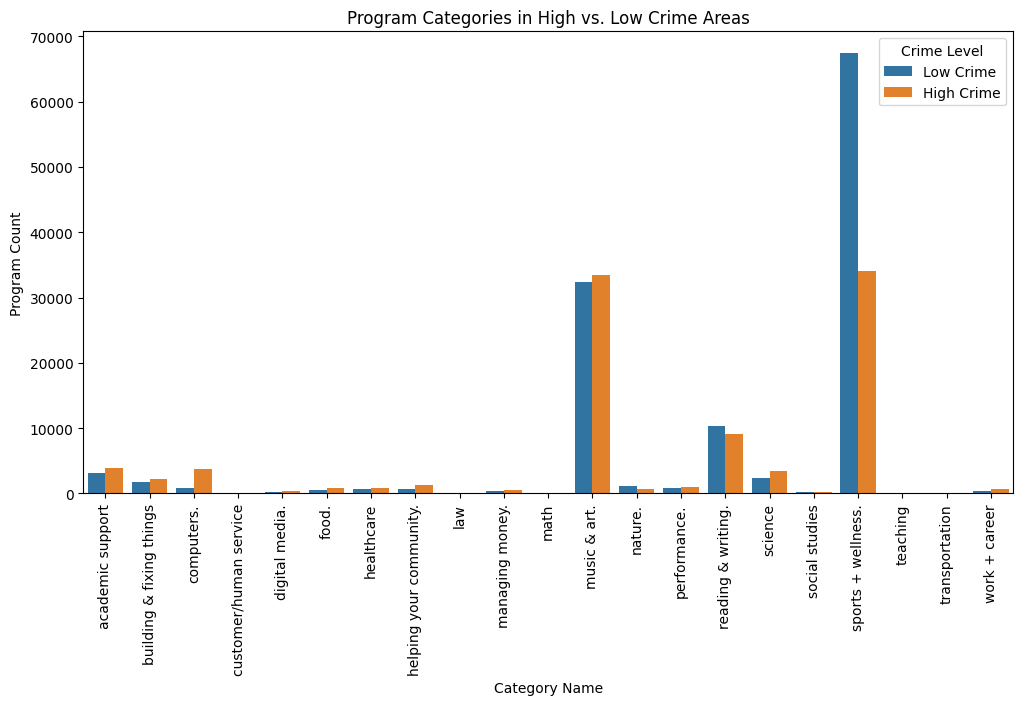

In [103]:
#| echo: false
#Standardize program category column
programs_df['Category Name'] = programs_df['Category Name'].str.strip().str.lower()
program_categories = programs_df.groupby(['Grid', 'Category Name']).size().reset_index(name='Program Count')

#Group crimes by Grid cell and then merge with program categories
crime_counts = crime_df.groupby('Grid').size().reset_index(name='Crime Count')
crime_program_data = pd.merge(crime_counts, program_categories, on='Grid', how='inner')

#Categorize areas as high or low crime and aggregate program counts by category and crime
crime_program_data['Crime Level'] = pd.qcut(crime_program_data['Crime Count'], q=2, labels=['Low Crime', 'High Crime'])
category_crime = crime_program_data.groupby(['Crime Level', 'Category Name'], observed = False)['Program Count'].sum().reset_index()

#Generate the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=category_crime, x='Category Name', y='Program Count', hue='Crime Level')
plt.xticks(rotation=90)
plt.title('Program Categories in High vs. Low Crime Areas')
plt.ylabel('Program Count')
plt.show()

Here, we can observe that the most popular program categories for both high-crime and low-crime areas are sports + wellness, music & art, and reading & writing. There does not seem to be a pattern between what program categories are typically offered in low-crime areas compared to high-crime areas, but it should be noted that programs that are more likely to be outdoors (sports + wellness and nature) are more popular in low crime areas than high crime areas and academia programs (academic support, computers, science) are more popular in high crime areas than low crime areas.

## Conclusions

We notice that there is a lack of bilingual/multilingual opportunities listed in the program directory, and that there is a lack of opportunities in general to the Hispanic population in the Chicagoland area. As the Hispanic population is also largely bilingual/multilingual, this shows an overall gap in accessibility to programs for the Hispanic population due to lack of bilingual/multilingual opportunities and/or lack of any opportunities altogether.

## Recommendations to stakeholder(s)

We found that Academic Support Programs are not as accessible to high schools with higher percentages of Hispanic students. In order to correct for this gap in accessibility, we suggest collaborating with Chicago Public High Schools with majority Hispanic student populations in order to provide Academic Support Programs close in proximity or even taking place inside of the schools directly after school hours as many programs begin during the school day, heavily affecting their accessibility. 

Limitations:
One possible limitation of this analysis is that it does not take into account proximity to Academic Support programs based on where individual students live. It is in fact very likely that students go to school in one area of Chicago and live in a different area that would potentially have more or less access to Academic Support Programs. Additionally, this analysis does not take into account access to modes of transportation that would potentially close the physical distance gap between students and Academic Support Programs. Having Academic Support Programs close to schools, although convenient, is not the only way to ensure access to these programs for students who need them most, which, for the purposes of this study, are students of low income and minority status. 

We also found that the bilingual/multilingual population in Chicago doesn’t have equitable access to opportunities that represent them based on a lack of bilingual/multilingual opportunities, specially non-Spanish opportunities, in addition to a misplacement of existing opportunities that fail to reach neighborhoods with high levels of non-English-only speakers and/or fail to represent their language prominence. One way to solve the lack of bilingual/multilingual opportunities is by taking advantage of cultural opportunities that already seek a potential bilingual/multilingual population (ex. Día de Muertos, Lunar New Year, etc.). Even if the organizers aren’t speakers of any languages other than English, by advertising their event as bilingual they are inviting the actual bilingual/multilingual population to provide said environment through their presence. Additionally, as many of these opportunities are offered by the Chicago Public Library there are many bilingual/multilingual resources offered by request. By predicting the linguistic identity of the target audience and making these resources available regardless of whether someone requested them or not, this can increase both the number of bilingual/multilingual opportunities and the participation of the bilingual/multilingual population as they would not need to request being accommodated. The third recommendation is to fix the found problem of the large number of bilingual/multilingual opportunities that fail to specify the languages that will be spoken. Our recommendation would be to include a ‘language’ category in the app where organizers can specify the languages used in their event, this would prevent lack of clarity for the target population and might help find a more accurate linguistic distribution of the existing programs. 

Limitations: 
Let’s keep in mind that for the purposes of our analysis “bilingual/multilingual” was defined as someone that spoke a language other than or in addition to English at home. However, the datasets used did not make a distinction between the two, therefore there could be an inclusion of monolingual non-English speakers that were considered bilingual based on this analysis. Yet, the existence of bilingual/multilingual opportunities in the languages of these monolingual non-English speakers included in the analysis still serves them as it invites them to a space where their language is used to some extent. 

Finally, we found that there was a negative regression coefficient between youth-program count and crime count in a respective grid cell. Despite the coefficient not being statistically significant, the negative coefficient suggests a potential protective effect. We recommend that there be further investment in youth-oriented programs in high-crime areas, as they can be beneficial so long as there is monitoring to evaluate their impact. Stakeholders should also focus on the quality, type, and location of programs instead of increasing the number of programs without strategic planning. As noted on the bar graphs, the most popular programs in high crime areas are sports + wellness, music & art, reading & writing, and science, all of which relate to some form of academia. Simply increasing the number of programs does not necessarily reduce crime as seen in the positive, statistically significant coefficient, but more programs that are strategically placed and encourage academia or intervention-type programs can be beneficial in reducing crime. 

Limitations: 
A possible limitation of this analysis is that the code does not primarily look into the impact of youth-related crimes when comparing them to youth-programs. It is possible that there would be a stronger correlation between the two and a more impactful regression coefficient because of the interventive nature of youth-programs because the coefficient was not statistically significant. The analysis also does not consider the socioeconomic status, population density, or pre-existing infrastructure of the location, which could influence both crime rates and program availability. 

## Appendix {-}

*Giovanni Cacciato*

Text(0.5, 1.0, 'Percent of CPS White Students v.\n Number of Near Programs')

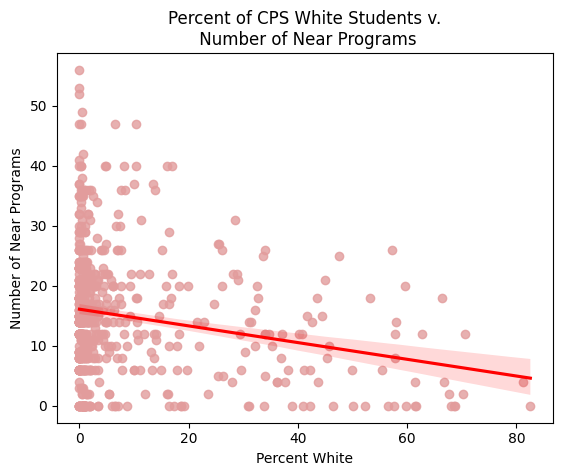

In [104]:
#| echo: false

sns.regplot(x='Percent White', y='Number of Near Programs', data=merged_df, scatter_kws={'color': '#E29C9C'}, line_kws={"color": "red"})
plt.title('Percent of CPS White Students v.\n Number of Near Programs')